# ch 16_8 SARIMAX

지금까지 배운 ARIMA, SARIMA 모델 등은 시간에 흐름에 따른 종속 변수의 변화만 고려했습니다. 여기에 exogenous variable, 외생 변수의 영향을 포함시킨 것이 SARIMAX 모델입니다.

예를들어 치킨집의 매출 시계열 데이터가 주어졌다고 가정하겠습니다. 국가대표 스포츠 경기가 있는 날엔 치킨집의 매출이 급증합니다만, 시간만 고려한 모델은 이를 반영하지 못합니다. 이런 외생 변수를 시계열 모델에 포함시킬 수 있는 모델이 SARIMAX입니다.

## 데이터 셋 준비

데이터 셋 링크: https://www.kaggle.com/datasets/prakharprasad/time-series-data-1?select=RestaurantVisitors.csv  
참고 자료: https://www.kaggle.com/code/prakharprasad/restaurant-visitors-forecast-with-sarimax/log

In [19]:
from utils import load_restaurant

train_df, test_df = load_restaurant()

In [20]:
train_df["weekend"] = train_df["weekday"].apply(lambda x: 1 if x in ["Saturday", "Sunday"] else 0)
test_df["weekend"] = test_df["weekday"].apply(lambda x: 1 if x in ["Saturday", "Sunday"] else 0)

<Axes: xlabel='date'>

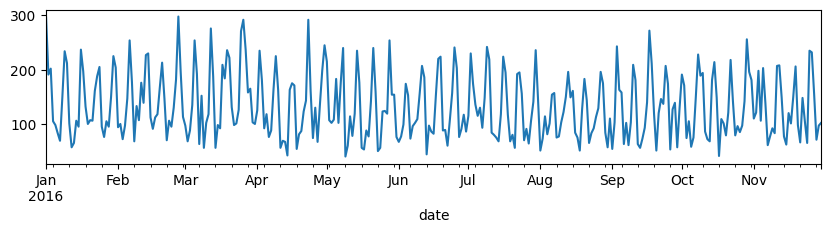

In [21]:
train_df["total"].plot(figsize=(10, 2))

<Axes: xlabel='date'>

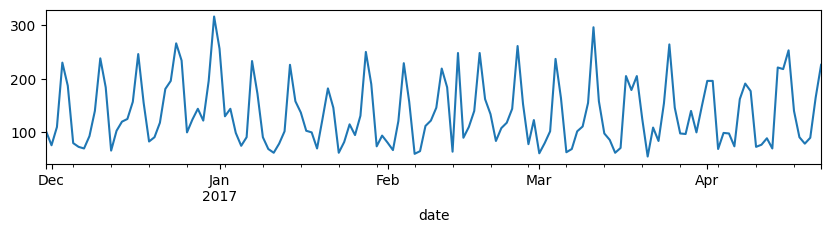

In [22]:
test_df["total"].plot(figsize=(10, 2))

### 계절성 확인

계절성 확인을 위해서 ACF plot을 그려보면 7일의 주기를 가짐을 알 수 있습니다.

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


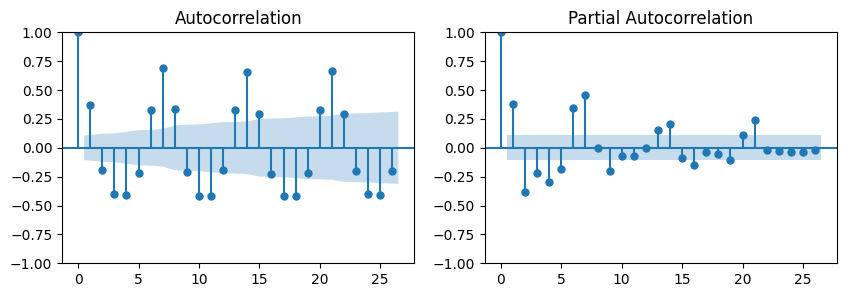

In [23]:
from utils import plot_acf_pacf

plot_acf_pacf(train_df, "total")

### 차분, 계절 차분 적용

학습용 데이터 셋에 차분, 계절 차분을 적용한 뒤, acf와 pacf plot을 그려보겠습니다.

In [24]:
train_df["diff"] = train_df["total"].diff()
train_df["seasonal_diff"] = train_df["total"].diff(7)

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


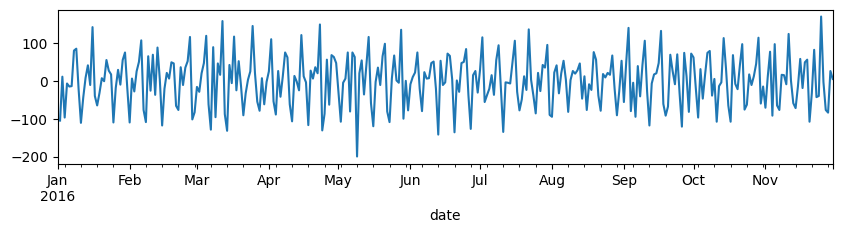

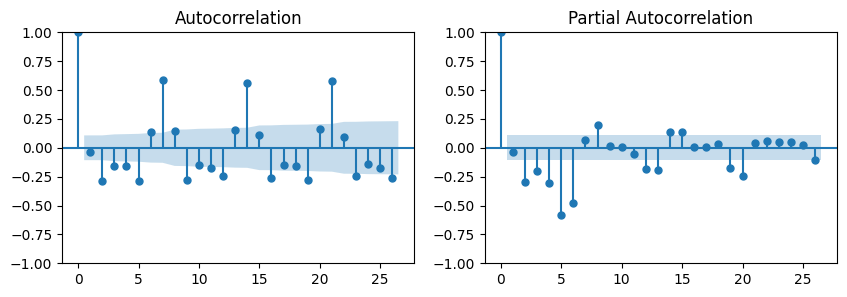

In [27]:
train_df["diff"].plot(figsize=(10, 2))
plot_acf_pacf(train_df, "diff")

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


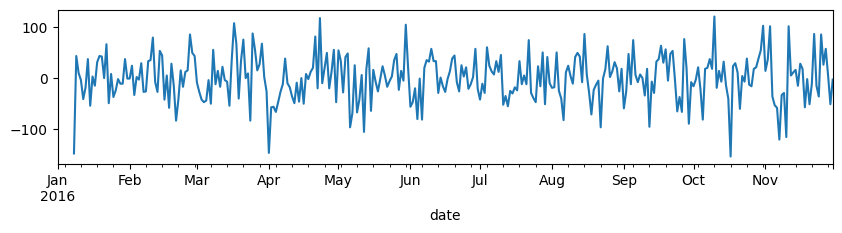

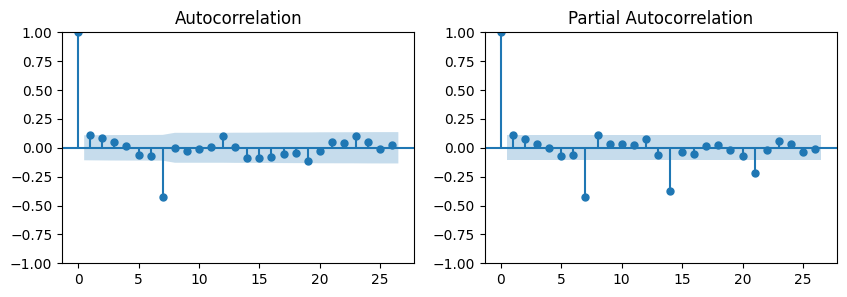

In [28]:
train_df["seasonal_diff"].plot(figsize=(10, 2))
plot_acf_pacf(train_df, "seasonal_diff")

## SARIMA 

### 모델 학습
외생 변수의 영향을 파악하기 위해서 먼저 SARIMA 모델을 학습시키고, 예측 결과를 시각화 해보겠습니다. auto_arima와 train set으로 모델을 학습시키겠습니다.

In [29]:
from pmdarima import auto_arima

sarima_model = auto_arima(
    train_df["total"], 
    seasonal=True, 
    m=7,
    D=1,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3424.363, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3351.566, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3422.375, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=3422.216, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=3307.075, Time=0.78 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=3310.818, Time=0.45 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=3306.974, Time=0.91 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=3352.350, Time=0.37 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=3306.998, Time=0.93 s

### 인퍼런스

test set에 대해서 예측을 내려보겠습니다.

In [30]:
train_df["SARIMA"] =sarima_model.predict_in_sample()
test_df["SARIMA"] = sarima_model.predict(n_periods=len(test_df))

### 결과 시각화

공휴일을 함께 시각화해보면 공휴일에 SARIMA 모델이 예측한 값보다 실제 방문객이 많음을 알 수 있습니다. 즉, 공휴일이라는 외생 변수를 모델에 추가할 경우, 성능 향상을 기대할 수 있습니다.

(17155.0, 17173.0)

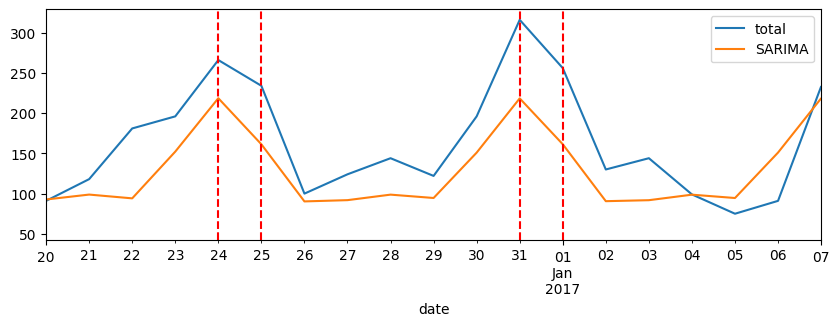

In [31]:
from matplotlib import pyplot as plt
import pandas as pd

test_df[["total", "SARIMA"]].plot(figsize=(10, 3))
holidays = test_df[test_df["holiday"]==1].index.values
for holiday in holidays:
    plt.axvline(x=holiday, color="red", linestyle="--")
plt.xlim(pd.Timestamp("2016-12-20"), pd.Timestamp("2017-01-07"))

## SARIMAX 모델 학습

SARIMAX 모델은 SARIMA와 달리 auto_arima로 바로 학습시킬 수가 없습니다. 때문에 먼저 auto_arima로 적합한 파라미터를 찾고, 이를 이용하여 statsmodels에 내장된 SARIMAX 모델을 학습시켜야 합니다. 외생 변수의 영향을 모델에 포함시키기 위해서 exogeneous 옵션에 holiday를 넣어주겠습니다.

### auto_arima를 이용한 파라미터 탐색

In [32]:
from pmdarima import auto_arima

auto_sarimax_model = auto_arima(
    train_df["total"], 
    exogeneous=train_df[["holiday"]],
    seasonal=True, 
    D=1,
    m=7, 
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3424.363, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3351.566, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3422.375, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=3422.216, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=3307.075, Time=0.66 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=3310.818, Time=0.30 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=3306.974, Time=0.84 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=3352.350, Time=0.37 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=3306.998, Time=0.84 s

### SARIMAX 모델 학습

train set과 auto_arima를 이용해 탐색한 파라미터를 가지고 SARIMAX 모델을 학습시킵니다. 마찬가지로 exog에 holiday를 넣어줍니다.

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    train_df["total"],
    exog=train_df[["holiday"]],
    order=auto_sarimax_model.order,
    seasonal_order=auto_sarimax_model.seasonal_order
).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76394D+00    |proj g|=  4.74290D-02


 This problem is unconstrained.



At iterate    5    f=  4.74412D+00    |proj g|=  2.72355D-02

At iterate   10    f=  4.70889D+00    |proj g|=  9.48724D-02

At iterate   15    f=  4.68590D+00    |proj g|=  1.48148D-03

At iterate   20    f=  4.68583D+00    |proj g|=  6.07386D-03

At iterate   25    f=  4.68577D+00    |proj g|=  1.39718D-04

At iterate   30    f=  4.68575D+00    |proj g|=  1.49472D-03

At iterate   35    f=  4.68562D+00    |proj g|=  6.87503D-04

At iterate   40    f=  4.68562D+00    |proj g|=  1.23068D-04

At iterate   45    f=  4.68562D+00    |proj g|=  2.42509D-04

At iterate   50    f=  4.68561D+00    |proj g|=  3.61580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 인퍼런스

In [34]:
train_df["SARIMAX"] = sarimax_model.predict(exog=train_df[["holiday"]])
test_df["SARIMAX"] = sarimax_model.forecast(steps=len(test_df), exog=test_df[["holiday"]])

### 결과 시각화

SARIMA 모델과 비교를 해보면 공휴일에 실제 방문객과 더 근접하게 예측값을 내려주는 것을 확인할 수 있습니다.

(17155.0, 17173.0)

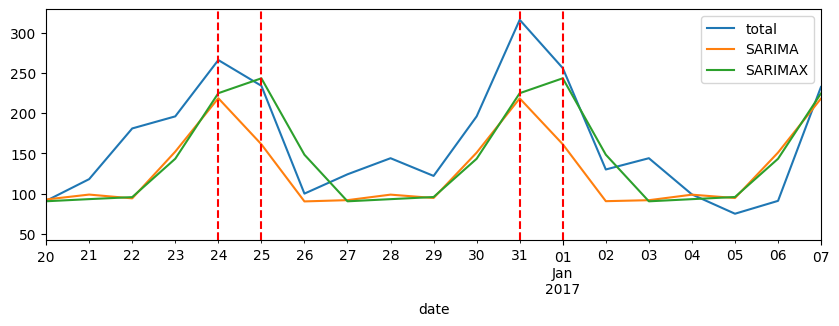

In [35]:
test_df[["total", "SARIMA", "SARIMAX"]].plot(figsize=(10, 3))
holidays = test_df[test_df["holiday"]==1].index.values
for holiday in holidays:
    plt.axvline(x=holiday, color="red", linestyle="--")
plt.xlim(pd.Timestamp("2016-12-20"), pd.Timestamp("2017-01-07"))

## 메트릭 비교

SARIMA 모델과 SARIMAX 모델의 RMSE를 비교해보면 train set에서는 SARIMAX의 결과가 더 좋지만, test set에서는 SARIMA 모델이 조금 더 좋습니다. 이는 아마도 test set에 포함된 공휴일의 수가 적어서 발생한 현상으로 추측됩니다.

In [36]:
from utils import calculate_rmse

calculate_rmse(train_df, "total", "SARIMA") 
calculate_rmse(train_df, "total", "SARIMAX") 
calculate_rmse(test_df, "total", "SARIMA") 
calculate_rmse(test_df, "total", "SARIMAX")

SARIMA RMSE: 41.22243058046318
SARIMAX RMSE: 36.21583201904645
SARIMA RMSE: 33.15999955433352
SARIMAX RMSE: 35.51158808805848


## 정리

이번 챕터에서는 외생 변수의 영향을 함께 고려할 수 있는 SARIMAX 모델에 대해서 배워봤습니다. 그리고 대표적인 외생 변수인 공휴일 여부를 포함하여 SARIMAX 모델을 학습시켰고, SARIMA 모델과 성능을 비교해보았습니다.